# ACCELERATE DIFFUSION MODELS FOR MEDICAL SEGMENTATION

In [1]:
import os
import time

import torch
import torchvision.transforms as transforms

from guided_diffusion.bratsloader import BRATSDataset
from guided_diffusion.utils import post_process, visualize, dice_coeff
from guided_diffusion.script_util import create_model_and_diffusion

import warnings
warnings.filterwarnings('ignore')

input_img = 'BraTS20_001'
optimization = 'Intel(R) Extension for PyTorch*'

## Load dataset

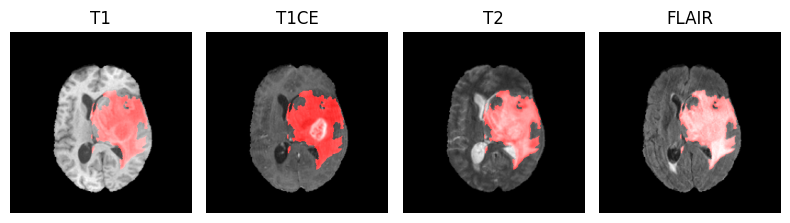

In [2]:
tran_list = [transforms.Resize((256,256))]
transform_test = transforms.Compose(tran_list)

ds = BRATSDataset(f'data/MICCAI_BraTS2020/{input_img}', transform_test)

datal = torch.utils.data.DataLoader(
    ds,
    batch_size=1,
    shuffle=True)

b, m, slice_ID = next(iter(datal))  #should return an image from the dataloader "data"
_, _, _, _ = visualize(b, m)

## Define and execute model

In [12]:
diffusion_steps = 25

model, diffusion = create_model_and_diffusion(image_size=256, in_ch=5, diffusion_steps=diffusion_steps, version=1)
model.eval()

if optimization=='Intel(R) Extension for PyTorch*':
    import intel_extension_for_pytorch as ipex
    model = ipex.optimize(model, dtype=torch.bfloat16)
    
c = torch.randn_like(b[:, :1, ...])
img = torch.cat((b, c), dim=1)     #add a noise channel$

model_kwargs = {}

sample_fn = diffusion.p_sample_loop_known

start_time = time.time()

if optimization=='Intel(R) Extension for PyTorch*':
    print(f"Intel(R) Extension for PyTorch* : {optimization}")
    print("Inferencing...")
    with torch.no_grad(), torch.cpu.amp.autocast():
        sample, _, _, _, _ = sample_fn(
            model,
            (1, 5, 256, 256), img, optimization,
            step = diffusion_steps,
            clip_denoised=True,
            model_kwargs=model_kwargs,
        )
else:
    print(f"Intel(R) Extension for PyTorch* : {optimization}")
    print("Inferencing...")
    sample, _, _, _, _ = sample_fn(
        model,
        (1, 5, 256, 256), img, 
        optimization,
        step = diffusion_steps,
        clip_denoised=True,
        model_kwargs=model_kwargs,
    )

ensemble_step_time = time.time() - start_time
post_processed_m = post_process(sample)
dice_score = f"Dice Coefficient: {dice_coeff(post_processed_m, m):.2f}"

print("...complete")

Intel(R) Extension for PyTorch* : Enabled
Inferencing...
...complete


## Visualize and acquire metrics

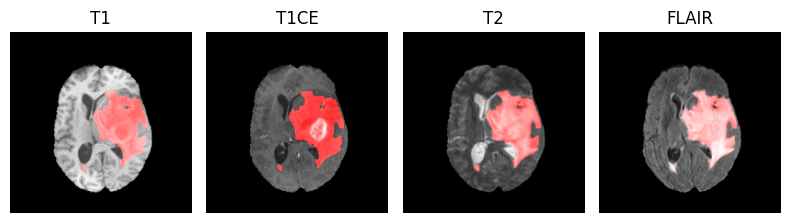

Inference Latency: 20.10 s
Dice Coefficient: 0.93


In [13]:
_, _, _, _ = visualize(b, post_processed_m)

print(f"Inference Latency: {ensemble_step_time:.2f} s")
print(dice_score)

### Additional Details
This tool is intended for demonstration purposes only and does not provide medical advice or information.  
The model used in this demonstration is a replication of the cited work and not the original model. We make no explicit claims regarding performance or accuracy numbers.  

Hardware Configuration:  
Software Configuration:  

**MedSegDiff**

J. Wu, H. Fang, Y. Zhang, Y. Yang, and Y. Xu, *MedSegDiff: Medical Image Segmentation with Diffusion Probabilistic Model*, Proceedings of Machine Learning Research – nnn:1–17, 2023 [[Code](https://github.com/WuJunde/MedSegDiff), [Paper](https://openreview.net/pdf?id=Jdw-cm2jG9)]

**BraTS 2020 Dataset**

B. H. Menze, A. Jakab, S. Bauer, J. Kalpathy-Cramer, K. Farahani, J. Kirby, et al. "The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS)", IEEE Transactions on Medical Imaging 34(10), 1993-2024 (2015) DOI: 10.1109/TMI.2014.2377694 (opens in a new window)

S. Bakas, H. Akbari, A. Sotiras, M. Bilello, M. Rozycki, J.S. Kirby, et al., "Advancing The Cancer Genome Atlas glioma MRI collections with expert segmentation labels and radiomic features", Nature Scientific Data, 4:170117 (2017) DOI: 10.1038/sdata.2017.117(opens in a new window)

S. Bakas, M. Reyes, A. Jakab, S. Bauer, M. Rempfler, A. Crimi, et al., "Identifying the Best Machine Learning Algorithms for Brain Tumor Segmentation, Progression Assessment, and Overall Survival Prediction in the BRATS Challenge", arXiv preprint arXiv:1811.02629 (2018)

S. Bakas, H. Akbari, A. Sotiras, M. Bilello, M. Rozycki, J. Kirby, et al., "Segmentation Labels and Radiomic Features for the Pre-operative Scans of the TCGA-GBM collection", The Cancer Imaging Archive, 2017. DOI: 10.7937/K9/TCIA.2017.KLXWJJ1Q(opens in a new window)

S. Bakas, H. Akbari, A. Sotiras, M. Bilello, M. Rozycki, J. Kirby, et al.,(opens in a new window) "Segmentation Labels and Radiomic Features for the Pre-operative Scans of the TCGA-LGG collection", The Cancer Imaging Archive, 2017. DOI: 10.7937/K9/TCIA.2017.GJQ7R0EF